In [3]:
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import numpy as np
import math
import os

# Observing DEAP

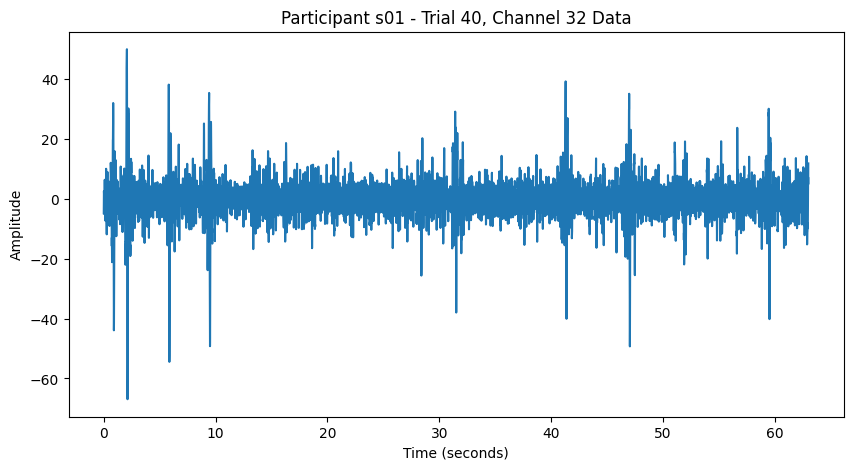

In [61]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to the mat file for participant s01
mat_file_path = 'E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/deap/data_preprocessed_matlab/s02.mat'

# Load the mat file
mat_data = scipy.io.loadmat(mat_file_path)

# Extract data and labels
data = mat_data['data']  # Shape: (40, 40, 8064)
labels = mat_data['labels']  # Shape: (40, 4)

# Choose a specific trial and channel to visualize
trial_index = 39  # Replace with the desired trial index (0 to 39)
channel_index = 31  # Replace with the desired channel index (0 to 39)

# Get the data for the chosen trial and channel
trial_channel_data = data[trial_index, channel_index, :]

# Calculate time axis in seconds
fs = 128  # Sampling frequency
time_axis = np.arange(0, len(trial_channel_data)) / fs

# Plot the data for the chosen trial and channel
plt.figure(figsize=(10, 5))
plt.plot(time_axis, trial_channel_data)
plt.title(f'Participant s01 - Trial {trial_index + 1}, Channel {channel_index + 1} Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


# There is No Delta Channel Band

In [67]:
fs = 128  # Adjusted to match DEAP dataset's sampling frequency
fStart = [1, 4, 8, 14, 31]
fEnd = [3, 7, 13, 30, 50]

b, a = signal.butter(4, [fStart[0]/fs, fEnd[0]/fs], 'bandpass')
filtered_data = signal.filtfilt(b, a, trial_data)



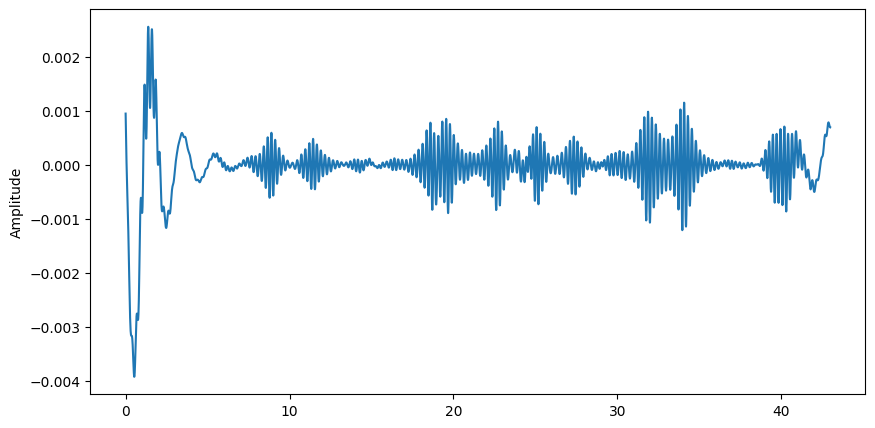

In [69]:
channel_index = 0  # Replace with the desired channel index (0 to 39)

start_index = 10 * fs
end_index = -10 * fs
# Get the data for the chosen trial and channel
trial_channel_data = filtered_data[channel_index, start_index:end_index]

# Calculate time axis in seconds
fs = 128  # Sampling frequency
time_axis = np.arange(0, len(trial_channel_data)) / fs

# Plot the data for the chosen trial and channel
plt.figure(figsize=(10, 5))
plt.plot(time_axis, trial_channel_data)

plt.ylabel('Amplitude')
plt.show()

# DE Calculation 

In [70]:
def compute_DE(signal):
    variance = np.var(signal, ddof=1)
    return math.log(2 * math.pi * math.e * variance) / 2

In [71]:
def load_data(data_dir): 
    fs = 128  # Adjusted to match DEAP dataset's sampling frequency
    fStart = [4, 8, 14, 31]
    fEnd = [7, 13, 30, 45]
    selected_channels = range(32)  # Adjusted to include only the first 32 channels
    seconds_to_exclude = 10

    datasets_X, datasets_y = [], []

    for filename_data in os.listdir(data_dir):
        if filename_data.endswith(".mat"):
            # Load data and labels
            mat_data = loadmat(os.path.join(data_dir, filename_data))
            data = mat_data['data']  # Shape: (40, 40, 8064)
            labels = mat_data['labels']  # Shape: (40, 4)

            for trial_index in range(data.shape[0]):
                dataset_X = []
                trial_data = data[trial_index, selected_channels, :]  # Selecting only the first 32 channels

                # Exclude the first and last 10 seconds
                start_index = seconds_to_exclude * fs
                end_index = -seconds_to_exclude * fs

                trial_data = trial_data[:, start_index:end_index]

                for band_index, band in enumerate(fStart):
                    b, a = signal.butter(4, [fStart[band_index]/fs, fEnd[band_index]/fs], 'bandpass')
                    filtered_data = signal.filtfilt(b, a, trial_data)
                    filtered_data_de = []

                    for lead in selected_channels:
                        lead_de = []
                        for de_index in range(0, filtered_data.shape[1] - fs, fs):
                            data_segment = filtered_data[lead, de_index: de_index + fs]
                            lead_de.append(compute_DE(data_segment))

                        filtered_data_de.append(lead_de)

                    dataset_X.append(filtered_data_de)

                datasets_X.append(dataset_X)
                datasets_y.append(labels[trial_index])

    datasets_X, datasets_y = np.array(datasets_X), np.array(datasets_y)

    return datasets_X, datasets_y

In [72]:
data_dir = "E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/DEAP/data_preprocessed_matlab/"

datasets_X, datasets_y = load_data(data_dir)
print(datasets_X.shape)
print(datasets_y.shape)

(1280, 4, 32, 42)
(1280, 4)


In [73]:
new_datasets_X = np.copy(datasets_X)
new_datasets_X = np.transpose(new_datasets_X, (0, 2, 3, 1))
print(new_datasets_X.shape)

(1280, 32, 42, 4)


In [ ]:
np.save('DEAP_DE_X.npy', new_datasets_X)
np.save('DEAP_DE_y.npy', datasets_y)